In [21]:
import pandas as pd
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import tree

In [2]:
in_file_name = 'data/runs_ju.tsv'
runs = pd.read_csv(in_file_name, delimiter="\t")

In [23]:
runs
#x = runs.team_id.values
#x = runs.as_matrix(["team_id", "leg_nro"])
x = runs.as_matrix(["leg_nro"])
y = runs.pace.values
print(x) # prints: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
x = x.reshape(len(x), 1)
#x = x.reshape(len(x), 2)
y = y.reshape(len(y), 1)

[[1]
 [6]
 [4]
 ...
 [6]
 [4]
 [5]]


In [24]:
x.shape

(64201, 1)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=2)

In [26]:
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
regr.coef_

array([[0.13510167]])

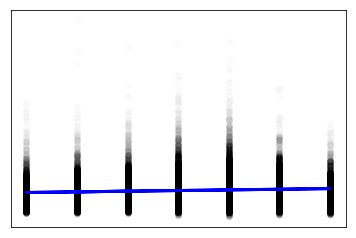

In [27]:


# plot it as in the example at http://scikit-learn.org/
plt.scatter(x_train, y_train,  color='black', alpha=0.01)
plt.plot(x_train, regr.predict(x_train), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [28]:
# Make predictions using the testing set
y_pred = regr.predict(x_test)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
y_pred

Mean squared error: 8.80
Variance score: 0.01


array([[10.7229093 ],
       [10.7229093 ],
       [10.18250261],
       ...,
       [10.7229093 ],
       [10.58780763],
       [ 9.91229926]])

In [29]:
rf = RandomForestRegressor(random_state=0, verbose=1)
rf.fit(x_train, y_train.ravel())

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=1, warm_start=False)

In [30]:
# Make predictions using the testing set
rf_y_pred = rf.predict(x_test)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))


Mean squared error: 8.49
Variance score: 0.04


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


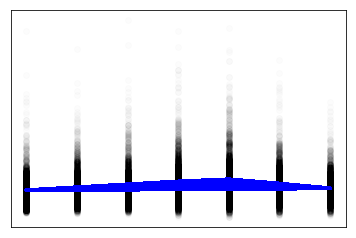

In [31]:
# plot it as in the example at http://scikit-learn.org/
plt.scatter(x_test, y_test,  color='black', alpha=0.01)
plt.plot(x_test, rf.predict(x_test), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [32]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1)
y_rbf_pred = svr_rbf.fit(x_train, y_train.ravel()).predict(x_test)

In [33]:


print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_rbf_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_rbf_pred))


Mean squared error: 8.67
Variance score: 0.02


In [34]:
clf = tree.DecisionTreeRegressor()
clf.fit(x_train, y_train.ravel())
# Make predictions using the testing set
y_clf_pred = clf.predict(x_test)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_clf_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_clf_pred))


Mean squared error: 8.48
Variance score: 0.04
